# Advanced Time Series Forecasting for Retail: A Comparative Study

# Author: Amina Abacon

# Part 3: Statistical Baseline Models

In [1]:
# Import data and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, SeasonalNaive

# ============================================================================
# STEP 1: Load Data with Features
# ============================================================================
print("\n[1] Loading Data...")
print("-" * 70)

df = pd.read_csv('data/processed/train_with_features.csv', parse_dates=['ds'])

print(f"✓ Loaded data: {df.shape}")
print(f"Time Series: {df['unique_id'].nunique()}")
print(f"Date Range: {df['ds'].min().date()} to {df['ds'].max().date()}")


[1] Loading Data...
----------------------------------------------------------------------
✓ Loaded data: (109650, 17)
Time Series: 150
Date Range: 2015-08-16 to 2017-08-15


In [2]:
# ============================================================================
# STEP 2: Train/Test Split
# ============================================================================
print("\n[2] Creating Train/Test Split...")
print("-" * 70)

test_days = 7
max_date = df['ds'].max()
test_start = max_date - pd.Timedelta(days=test_days - 1)

train_df = df[df['ds'] < test_start].copy()
test_df = df[df['ds'] >= test_start].copy()

print(f"Train Set: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")
print(f"  Records: {len(train_df):,}")
print(f"  Time Series: {train_df['unique_id'].nunique()}")

print(f"\nTest Set: {test_df['ds'].min().date()} to {test_df['ds'].max().date()}")
print(f"  Records: {len(test_df):,}")
print(f"  Time Series: {test_df['unique_id'].nunique()}")



[2] Creating Train/Test Split...
----------------------------------------------------------------------
Train Set: 2015-08-16 to 2017-08-08
  Records: 108,600
  Time Series: 150

Test Set: 2017-08-09 to 2017-08-15
  Records: 1,050
  Time Series: 150


In [3]:
# ============================================================================
# STEP 3: Prepare Data for StatsForecast
# ============================================================================
print("\n[3] Preparing Data for StatsForecast...")
print("-" * 70)

# StatsForecast needs: unique_id, ds, y
train_sf = train_df[['unique_id', 'ds', 'y']].copy()
train_sf = train_sf.sort_values(['unique_id', 'ds']).reset_index(drop=True)

print(f"✓ Training data prepared: {train_sf.shape}")
print(f"✓ Forecasting {train_sf['unique_id'].nunique()} time series")
print(f"✓ Average series length: {len(train_sf) / train_sf['unique_id'].nunique():.0f} days")


[3] Preparing Data for StatsForecast...
----------------------------------------------------------------------
✓ Training data prepared: (108600, 3)
✓ Forecasting 150 time series
✓ Average series length: 724 days


In [4]:
# ============================================================================
# STEP 4: Initialize Statistical Models
# ============================================================================
print("\n[4] Initializing Statistical Models...")
print("-" * 70)

# Initialize models with weekly seasonality
models = [
    SeasonalNaive(season_length=7),     # Baseline: repeat last week
    AutoARIMA(season_length=7),          # ARIMA with auto parameter selection
    AutoETS(season_length=7),            # Exponential smoothing
    AutoTheta(season_length=7)           # Theta method
]

print("Models initialized:")
print("  1. SeasonalNaive - Repeats pattern from 7 days ago")
print("  2. AutoARIMA - Auto-tuned ARIMA model")
print("  3. AutoETS - Auto-tuned exponential smoothing")
print("  4. AutoTheta - Theta method forecasting")

# Create StatsForecast object
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,  # Use all CPU cores
    verbose=True
)

print("\n✓ StatsForecast initialized")


[4] Initializing Statistical Models...
----------------------------------------------------------------------
Models initialized:
  1. SeasonalNaive - Repeats pattern from 7 days ago
  2. AutoARIMA - Auto-tuned ARIMA model
  3. AutoETS - Auto-tuned exponential smoothing
  4. AutoTheta - Theta method forecasting

✓ StatsForecast initialized


In [5]:
# ============================================================================
# STEP 5: Train Models and Generate Forecasts
# ============================================================================
print("\n[5] Training Models and Generating Forecasts...")
print("-" * 70)

# Generate 7-day forecasts
forecast_df = sf.forecast(df=train_sf, h=7, level=[90])

print(f"\n✓ Forecasts generated!")
print(f"Forecast shape: {forecast_df.shape}")
print(f"\nSample forecasts:")
print(forecast_df.head(10))


[5] Training Models and Generating Forecasts...
----------------------------------------------------------------------


Forecast:   0%|          | 0/150 [Elapsed: 00:00]


✓ Forecasts generated!
Forecast shape: (1050, 14)

Sample forecasts:
               unique_id         ds  SeasonalNaive  SeasonalNaive-lo-90  \
0     store_10_BEVERAGES 2017-08-09         1250.0           701.144284   
1     store_10_BEVERAGES 2017-08-10         1569.0          1020.144284   
2     store_10_BEVERAGES 2017-08-11         1658.0          1109.144284   
3     store_10_BEVERAGES 2017-08-12         1819.0          1270.144284   
4     store_10_BEVERAGES 2017-08-13         1671.0          1122.144284   
5     store_10_BEVERAGES 2017-08-14         1393.0           844.144284   
6     store_10_BEVERAGES 2017-08-15         1591.0          1042.144284   
7  store_10_BREAD/BAKERY 2017-08-09          103.0            51.455347   
8  store_10_BREAD/BAKERY 2017-08-10          101.0            49.455347   
9  store_10_BREAD/BAKERY 2017-08-11           99.0            47.455347   

   SeasonalNaive-hi-90    AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
0          1798.855716  1164.85

In [11]:
# ============================================================================
# STEP 6: Evaluate Performance
# ============================================================================
print("\n[6] Evaluating Model Performance...")
print("-" * 70)

# Merge forecasts with actuals
eval_df = test_df[['unique_id', 'ds', 'y']].merge(
    forecast_df.reset_index(),
    on=['unique_id', 'ds'],
    how='inner'
)

print(f"✓ Merged evaluation data: {eval_df.shape}")

def calculate_metrics(actual, predicted):
    """Calculate forecasting error metrics"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual = actual[mask]
    predicted = predicted[mask]
    
    if len(actual) == 0:
        return {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
    
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Calculate metrics for each model
model_names = ['SeasonalNaive', 'AutoARIMA', 'AutoETS', 'AutoTheta']
results = []

for model in model_names:
    if model in eval_df.columns:
        metrics = calculate_metrics(eval_df['y'], eval_df[model])
        metrics['Model'] = model
        metrics['Type'] = 'Statistical'
        results.append(metrics)

results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Type', 'MAE', 'RMSE', 'MAPE']].sort_values('MAE')

print("\n Statistical Model Performance:")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]['Model']
best_mae = results_df.iloc[0]['MAE']

print(f"\n Best Statistical Model: {best_model}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f}")
print(f"   MAPE: {results_df.iloc[0]['MAPE']:.2f}%")


[6] Evaluating Model Performance...
----------------------------------------------------------------------
✓ Merged evaluation data: (1050, 16)

 Statistical Model Performance:
        Model        Type        MAE       RMSE      MAPE
    AutoTheta Statistical 276.440998 591.382579 20.460391
      AutoETS Statistical 277.496892 590.140164 20.258641
    AutoARIMA Statistical 280.936919 596.284961 20.986229
SeasonalNaive Statistical 310.691249 610.989868 24.869624

 Best Statistical Model: AutoTheta
   MAE: 276.44
   RMSE: 591.38
   MAPE: 20.46%



[7] Creating Visualizations...
----------------------------------------------------------------------
✓ Saved: baseline_forecasts.png


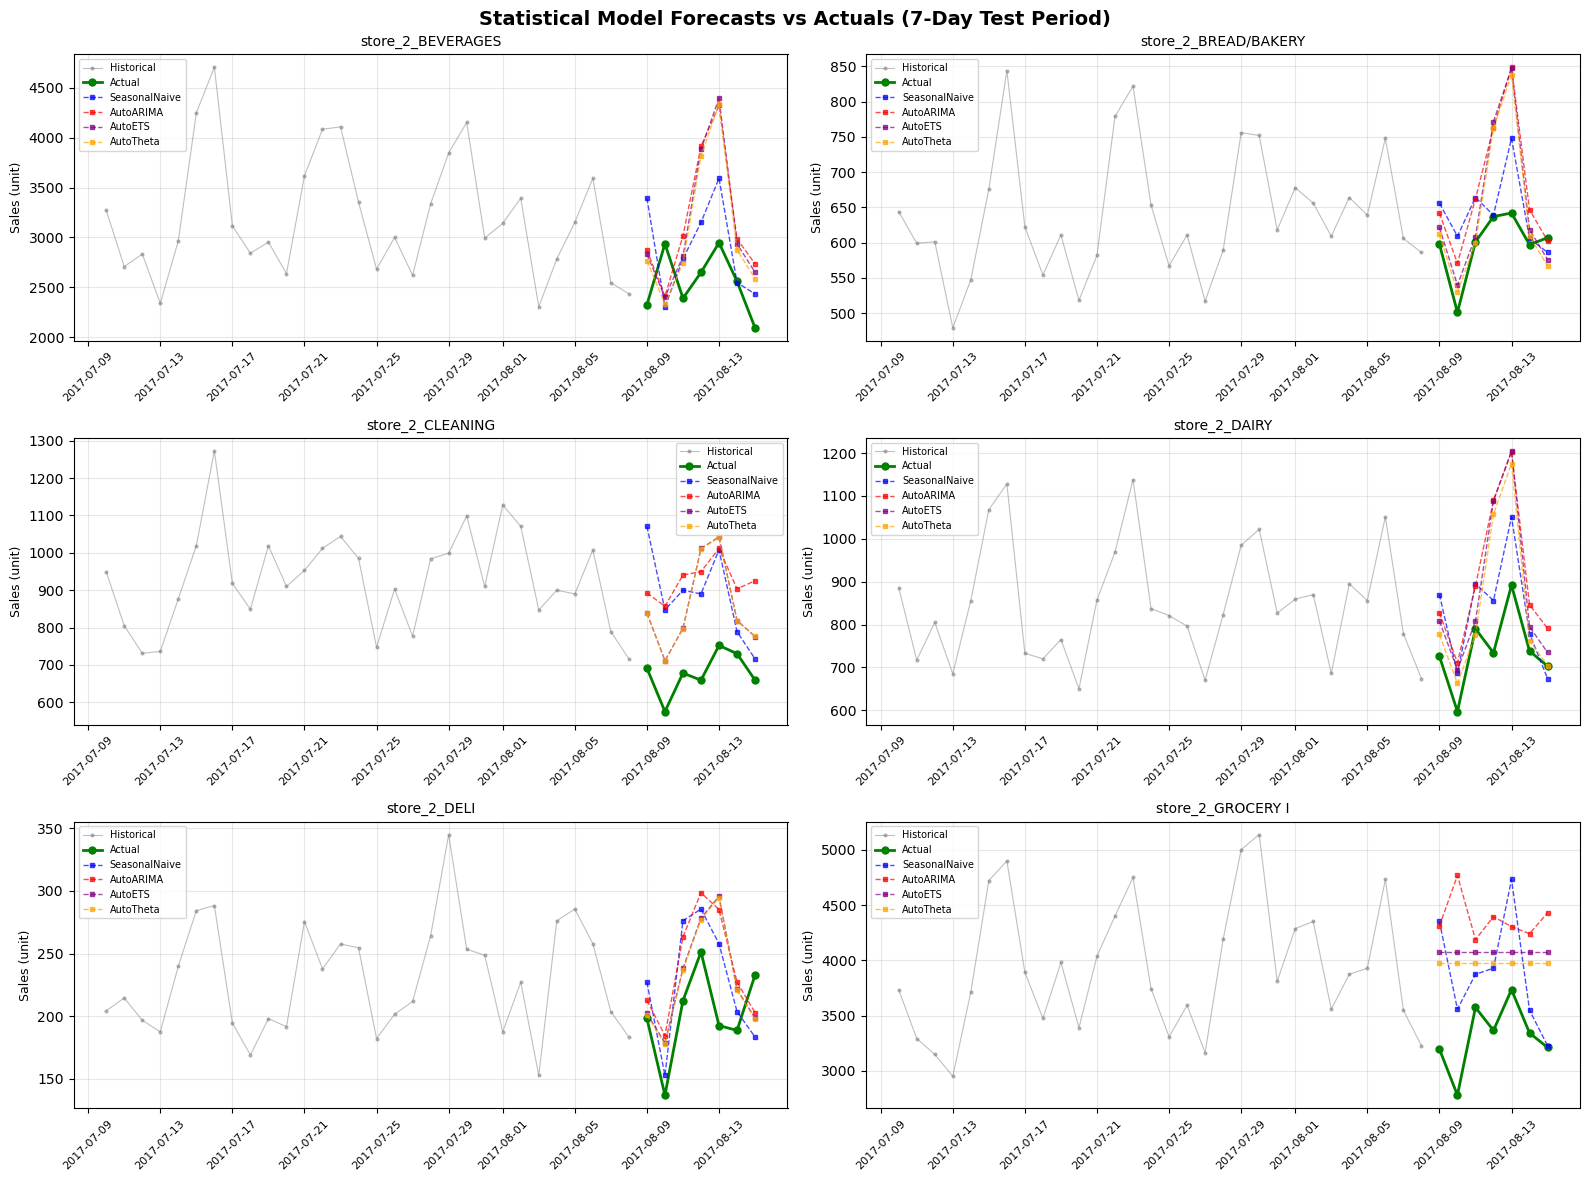

✓ Saved: baseline_comparison.png


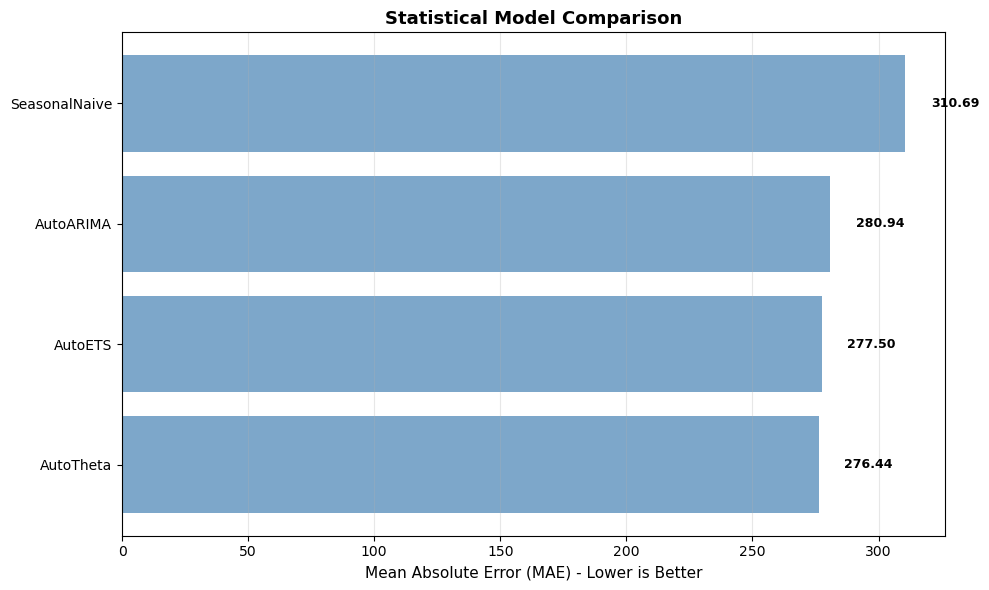

In [12]:
# ============================================================================
# STEP 7: Visualize Forecasts
# ============================================================================
print("\n[7] Creating Visualizations...")
print("-" * 70)

output_path = Path('output')

# Select representative series for visualization
viz_series = eval_df['unique_id'].unique()[:6]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Statistical Model Forecasts vs Actuals (7-Day Test Period)', 
             fontsize=14, fontweight='bold')

for idx, uid in enumerate(viz_series):
    ax = axes[idx // 2, idx % 2]
    
    # Historical (last 30 days)
    hist = train_df[train_df['unique_id'] == uid].tail(30)
    test_series = eval_df[eval_df['unique_id'] == uid]
    
    # Plot historical
    ax.plot(hist['ds'], hist['y'], 'o-', label='Historical', 
            color='gray', alpha=0.5, markersize=2, linewidth=0.8)
    
    # Plot actual
    ax.plot(test_series['ds'], test_series['y'], 'o-', label='Actual', 
            color='green', linewidth=2, markersize=5)
    
    # Plot forecasts
    colors = {'SeasonalNaive': 'blue', 'AutoARIMA': 'red', 
              'AutoETS': 'purple', 'AutoTheta': 'orange'}
    
    for model, color in colors.items():
        if model in test_series.columns:
            ax.plot(test_series['ds'], test_series[model], 
                    's--', label=model, color=color, alpha=0.7, markersize=3, linewidth=1)
    
    ax.set_title(uid, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Sales (unit)', fontsize=9)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.savefig(output_path / 'baseline_forecasts.png', dpi=300, bbox_inches='tight')
print("✓ Saved: baseline_forecasts.png")
plt.show()

# Model comparison chart
fig, ax = plt.subplots(figsize=(10, 6))
models = results_df['Model']
mae_values = results_df['MAE']

bars = ax.barh(range(len(models)), mae_values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models, fontsize=10)
ax.set_xlabel('Mean Absolute Error (MAE) - Lower is Better', fontsize=11)
ax.set_title('Statistical Model Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (mae, model) in enumerate(zip(mae_values, models)):
    ax.text(mae + 10, i, f'{mae:.2f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / 'baseline_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: baseline_comparison.png")
plt.show()

In [8]:
# ============================================================================
# STEP 8: Per-Series Performance Analysis
# ============================================================================
print("\n[8] Per-Series Performance Analysis...")
print("-" * 70)

# Calculate MAE per series for best model
series_performance = []
for uid in eval_df['unique_id'].unique():
    series_data = eval_df[eval_df['unique_id'] == uid]
    mae = np.mean(np.abs(series_data['y'] - series_data[best_model]))
    series_performance.append({'unique_id': uid, 'MAE': mae})

series_perf_df = pd.DataFrame(series_performance).sort_values('MAE')

print(f"\n{best_model} Performance by Time Series:")
print("\nBest 5 (Easiest to Forecast):")
print(series_perf_df.head().to_string(index=False))

print("\nWorst 5 (Hardest to Forecast):")
print(series_perf_df.tail().to_string(index=False))


[8] Per-Series Performance Analysis...
----------------------------------------------------------------------

AutoTheta Performance by Time Series:

Best 5 (Easiest to Forecast):
             unique_id       MAE
      store_32_POULTRY 10.084037
store_32_PERSONAL CARE 14.466005
 store_35_BREAD/BAKERY 15.458007
         store_43_DELI 15.582984
        store_32_MEATS 15.614598

Worst 5 (Hardest to Forecast):
         unique_id         MAE
 store_9_GROCERY I 1151.658630
store_44_GROCERY I 1542.388671
store_45_BEVERAGES 1641.213879
store_45_GROCERY I 1663.173384
store_44_BEVERAGES 1808.909063


In [9]:
# ============================================================================
# STEP 9: Save Results
# ============================================================================
print("\n[9] Saving Results...")
print("-" * 70)

# Save forecasts
forecast_df.to_csv(output_path / 'baseline_forecasts.csv')
print(f"✓ Saved: {output_path / 'baseline_forecasts.csv'}")

# Save evaluation data
eval_df.to_csv(output_path / 'baseline_eval.csv', index=False)
print(f"✓ Saved: {output_path / 'baseline_eval.csv'}")

# Save metrics
results_df.to_csv(output_path / 'baseline_results.csv', index=False)
print(f"✓ Saved: {output_path / 'baseline_results.csv'}")

# Save series performance
series_perf_df.to_csv(output_path / 'baseline_series_performance.csv', index=False)
print(f"✓ Saved: {output_path / 'baseline_series_performance.csv'}")


[9] Saving Results...
----------------------------------------------------------------------
✓ Saved: output\baseline_forecasts.csv
✓ Saved: output\baseline_eval.csv
✓ Saved: output\baseline_results.csv
✓ Saved: output\baseline_series_performance.csv


In [14]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 70)
print("STATISTICAL BASELINE MODELS COMPLETE")
print("=" * 70)

print(f"\n Results Summary:")
print(f"  Time Series Forecasted: {train_sf['unique_id'].nunique()}")
print(f"  Forecast Horizon: {test_days} days")
print(f"  Models Tested: {len(model_names)}")

print(f"\n Best Model: {best_model}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f}")
print(f"   MAPE: {results_df.iloc[0]['MAPE']:.2f}%")

print(f"\n Key Insights:")
avg_sales = df['y'].mean()
error_pct = (best_mae / avg_sales) * 100
print(f"  Average forecast error: {error_pct:.1f}% of daily sales")
print(f"  Average daily sales: {avg_sales:.2f}")

print(f"\n Generated Files:")
print(f"  - baseline_forecasts.png")
print(f"  - baseline_comparison.png")
print(f"  - baseline_forecasts.csv")
print(f"  - baseline_eval.csv")
print(f"  - baseline_results.csv")
print(f"  - baseline_series_performance.csv")

print(f"\n Baseline Established:")
print(f"  ✓ This MAE ({best_mae:.2f}) is what neural networks need to beat")
print(f"  ✓ Represents performance without external features")
print(f"  ✓ Industry-standard statistical approaches")

print(f"\n Next Step: Part 4 - Neural Networks (No Exogenous)")
print("=" * 70)


STATISTICAL BASELINE MODELS COMPLETE

 Results Summary:
  Time Series Forecasted: 150
  Forecast Horizon: 7 days
  Models Tested: 4

 Best Model: AutoTheta
   MAE: 276.44
   RMSE: 591.38
   MAPE: 20.46%

 Key Insights:
  Average forecast error: 17.1% of daily sales
  Average daily sales: 1616.80

 Generated Files:
  - baseline_forecasts.png
  - baseline_comparison.png
  - baseline_forecasts.csv
  - baseline_eval.csv
  - baseline_results.csv
  - baseline_series_performance.csv

 Baseline Established:
  ✓ This MAE (276.44) is what neural networks need to beat
  ✓ Represents performance without external features
  ✓ Industry-standard statistical approaches

 Next Step: Part 4 - Neural Networks (No Exogenous)


---